# Объединённая метрика: `FFT_dF` + `DTCWT_Entropy`
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json 

def load_sample(name):
    dt = pd.read_csv(f'../../data/GIAB/_las_noappr/{name}_p14.lasbed', sep=' ')
    dt['Name'] = name
    return dt

LB = pd.concat([load_sample(f'HG00{i}') for i in [1,2,3,4,5,6,7]])
LB = LB[LB['covered_bases'] > 0]

### Нормализация FFT и DT

В качестве основных метрик для объединённой метрики принимаем 
активную ширу спектра (FFT_dF) и энтропию четырёх уровней разложения 
для DTCWT (DTCWT_Entropy).

Предположим, что значения FFT_dF и DTCWT_Entropy распределены нормально
для всех регионов, которые мы можем считать хорошими. При этом для энтропии 
справедливо: чем больше значения, тем "спокойнее" регион. Для ширины спектра — 
чем шире, тем регион более "шумный" и неспокойный.

**По этой причине мы будем оценивать параметры распределения для FFT_dF по левой половине
а параметры для DTCWT_Entropy по правой половине гистограммы.**

– За мат.ожидание примем максимум функции плотности вероятности, оценённой по выборке.  
– Дисперсию оценим только по соотвествующей половине гистограммы:

In [2]:
def get_params(obj, by = 'L'):
    obj = np.array(obj)
    v, x = np.histogram(obj, bins=250)
    X = [(x[i] + x[i+1])/2 for i in range(len(v))]
    mean_i = np.argmax(v)
    coda = (obj[obj < X[mean_i]]) if by == 'L' else (obj[obj > X[mean_i]])
    sigma_v = np.sqrt(np.mean((coda - X[mean_i])**2))
    return (X[mean_i], sigma_v)

train = LB[LB['Name'].isin(['HG002', 'HG003', 'HG004'])]
fft_m, fft_s = get_params(train[train['FFT_dF'] < 2800]['FFT_dF'].to_list())
dtt_m, dtt_s = get_params(train[train['DTCWT_Entropy'] > 8.6]['DTCWT_Entropy'].to_list(), by='R')

print(f"fft_m, fft_s = ({fft_m}, {fft_s})")
print(f"dtt_m, dtt_s = ({dtt_m}, {dtt_s})")

fft_m, fft_s = (1928.1957682, 216.2054816965535)
dtt_m, dtt_s = (9.1154286, 0.01960891258940661)


Разделением регионов на каскад считаем такое:

In [3]:
def separate(T):
    V = [{
      'good': T.loc[(T['covered_bases'] == 1) & (T['acent'] == 0)],
      'bad':  T.loc[(T['covered_bases'] < 1) | (T['acent'] > 0)]
    }]
    V.append({
      'good': V[0]['good'][V[0]['good']['all_diff'] <= 0.8],
      'bad':  V[0]['good'][V[0]['good']['all_diff'] > 0.8]
    })
    V.append({
      'good': V[1]['good'][V[1]['good']['lc_vcf'] == 0],
      'bad':  V[1]['good'][V[1]['good']['lc_vcf'] > 0]
    })
    V.append({
      'good': V[2]['good'][V[2]['good']['hc_vcf'] <= 0.1],
      'bad':  V[2]['good'][V[2]['good']['hc_vcf'] > 0.1]
    })
    return V

In [4]:
LB['FFT_dF_n'] = (LB['FFT_dF'] - fft_m)/fft_s
LB['DTCWT_Entropy_n'] = -(LB['DTCWT_Entropy'] - dtt_m)/dtt_s
SLB = separate(LB)
train = LB[LB['Name'].isin(['HG002', 'HG003', 'HG004'])]
trainS = separate(train)

In [5]:
def viz(Sn, xs, ys):
    colors = ['#900', '#d4cf00', '#d49c00', '#004ad4', '#24d400']
    plt.figure(figsize=(12, 12))
    plt.grid()
    for i in range(4):
        plt.scatter(Sn[i]['bad'][xs], Sn[i]['bad'][ys], alpha=0.05, s=2.5, color=colors[i])
    plt.scatter(Sn[3]['good'][xs], Sn[3]['good'][ys], alpha=0.05, s=2.5, color=colors[-1])
    return plt

### 1. Линейная комбинация

На графике видно, что регионы V3 в области около 0 хорошо разделяются по оси Y (DTCWT).  
Используем линейную комбинацию:

In [6]:
nor7d = [(LB['FFT_dF'] - fft_m)/fft_s, -(LB['DTCWT_Entropy'] - dtt_m)/dtt_s]

In [7]:
def lComb(x_, y_): # From: -6 to 36
    K = (x_ + 5) / 35
    return K * x_ + (1-K) * y_

LB['lComb'] = [lComb(x_, y_) for x_, y_ in np.transpose(nor7d)]

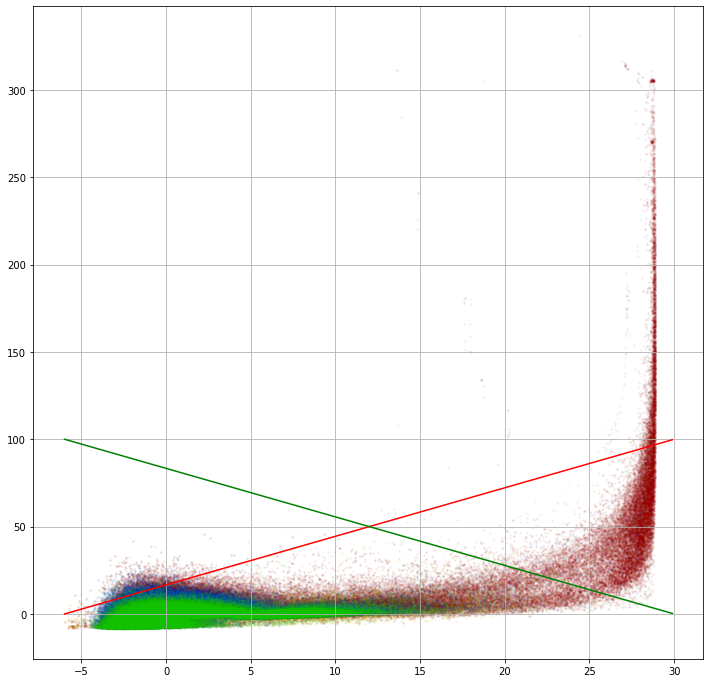

In [8]:
p = viz(SLB, 'FFT_dF_n', 'DTCWT_Entropy_n')
rx = np.arange(-6, 30, 0.1) 
ry = np.array([(i+6)/36 * 100 for i in rx])
p.plot(rx, ry, color='r')
p.plot(rx, 100 - ry, color='g')
p.show()

### 2. Плавный переход к FFT после `X=20` (через arctan)

In [9]:
def arcTan(x_, y_, n_): # From: -5 to 30
    K = np.arctan((x_ - 15)/n_)/(np.pi) + 0.5
    return K * x_ + (1-K) * y_

LB['arcTan2'] = [arcTan(x_, y_, 2) for x_, y_ in np.transpose(nor7d)]
LB['arcTan8'] = [arcTan(x_, y_, 8) for x_, y_ in np.transpose(nor7d)]

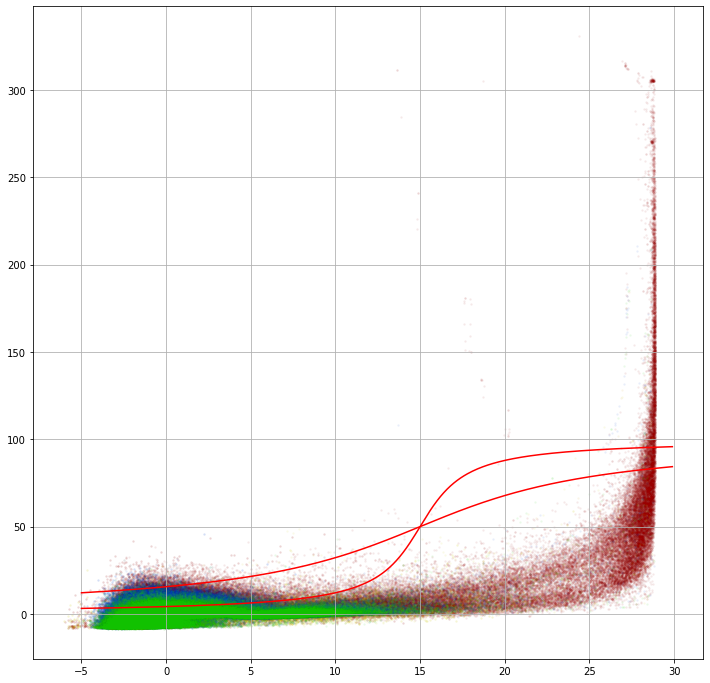

In [10]:
def ry_(rx, n):
    return np.array([(np.arctan((i-15)/n)/(np.pi) + 0.5)*100 for i in rx])

p = viz(SLB, 'FFT_dF_n', 'DTCWT_Entropy_n')
rx = np.arange(-5, 30, 0.1) 
p.plot(rx, ry_(rx, 2), color='r')
p.plot(rx, ry_(rx, 8), color='r')
p.show()

### 3. Гауссова функция: активация DTCWT "в начале" и "в конце"

In [11]:
def gauss(x_, y_, n_):
    K = (np.exp(-((x_ - 15)/n_)**2))
    return K * x_ + (1-K) * y_

LB['gauss4'] = [gauss(x_, y_, 4) for x_, y_ in np.transpose(nor7d)]
LB['gauss8'] = [gauss(x_, y_, 8) for x_, y_ in np.transpose(nor7d)]

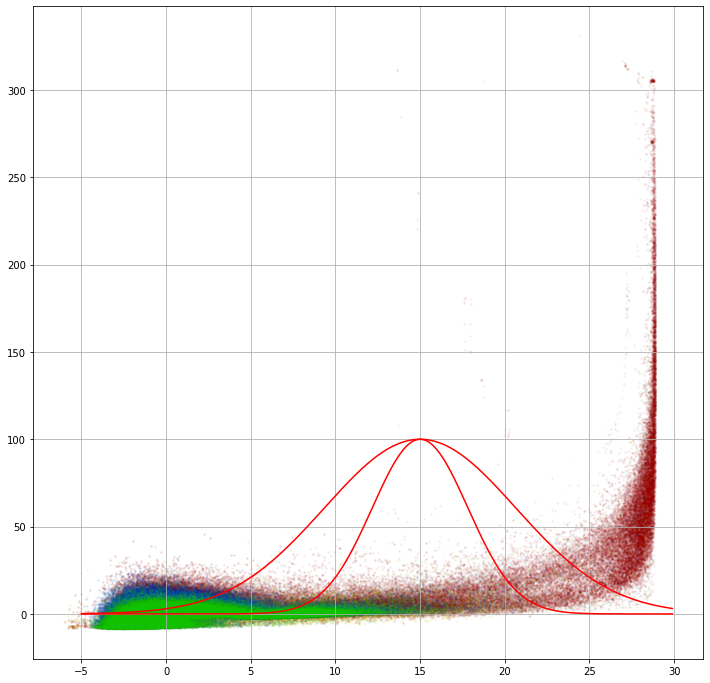

In [12]:
p = viz(SLB, 'FFT_dF_n', 'DTCWT_Entropy_n')
rx = np.arange(-5, 30, 0.1) 
ry = np.array([(np.exp(-((i-15)/4)**2))*100 for i in rx])
p.plot(rx, ry, color='r')
ry = np.array([(np.exp(-((i-15)/8)**2))*100 for i in rx])
p.plot(rx, ry, color='r')
p.show()

### 4. Сглаженная матрица значений

In [13]:
# trainS = separate(train)

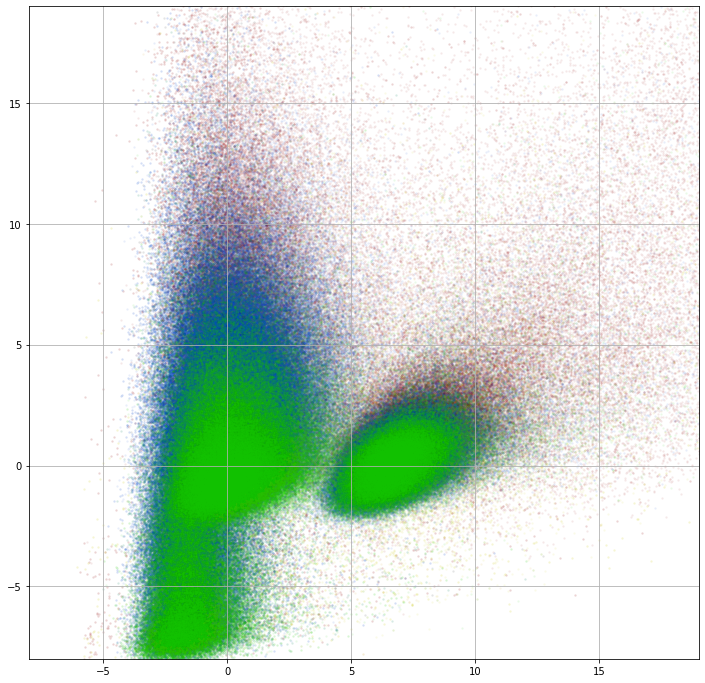

In [14]:
p = viz(SLB, 'FFT_dF_n', 'DTCWT_Entropy_n')
p.xlim(-8,19)
p.ylim(-8,19)
p.show()

In [15]:
from scipy.ndimage import gaussian_filter

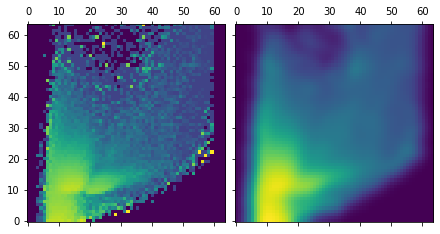

In [16]:
obj = SLB
bins = 64
xar, yar = (np.arange(-8, 32, 40/(bins+1)), np.arange(-8, 32, 40/(bins+1)))
n1, n2 = ('FFT_dF_n', 'DTCWT_Entropy_n')

counts = []
for i in range(4):
    counts.append(np.histogram2d(obj[i]['bad'][n1], obj[i]['bad'][n2], bins=(xar, yar))[0])
counts.append(np.histogram2d(obj[3]['good'][n1], obj[3]['good'][n2], bins=(xar, yar))[0])

tmp = np.zeros((bins, bins)) - 1
for x in range(bins):
    for y in range(bins):
        v = np.array([counts[l][x][y] for l in range(5)])
        if v.sum() > 0:
            tmp[x][y] = (v * np.arange(0, 5, 1) / v.sum()).sum()

tmp = tmp/np.max(tmp)
mat = gaussian_filter(tmp, sigma=2)

axs = (plt.figure(constrained_layout=True).subplots(1, 2, sharex=True, sharey=True))
axs[0].matshow(np.transpose(tmp), origin='lower')
axs[1].matshow(np.transpose(mat), origin='lower')
plt.show()

In [17]:
# model = json.dumps([mat.tolist(),xar.tolist(),yar.tolist()])
# mat, xar, yar = [np.array(e) for e in json.loads(model)]

with open('_matrix.v1.json', 'w') as f:
    json.dump([mat.tolist(), xar.tolist(), yar.tolist()], f)

In [18]:
# Globals: mat, xar, yar
def m_index(obj, v):
    if obj[0] > v or obj[-1] < v: return -1
    return np.where(obj <= v)[0][-1]

def byMatrix(x, y):
    i, j = (m_index(xar, x), m_index(yar, y))
    if i < 0 or j < 0: return -1
    return mat[i][j]

In [19]:
# Good
x_in, y_in = (2000, 9.1)
x_, y_ = ((x_in - fft_m)/fft_s, -(y_in - dtt_m)/dtt_s)
byMatrix(x_, y_)

0.7762329849834197

In [20]:
# Bad
x_in, y_in = (4500, 9)
x_, y_ = ((x_in - fft_m)/fft_s, -(y_in - dtt_m)/dtt_s)
byMatrix(x_, y_)

0.22535976241488642

In [21]:
LB['matrix'] = [byMatrix(x_, y_) for x_, y_ in np.transpose(nor7d)]

In [22]:
def get_AUC(Vn, by):
    dt = np.array(
      [[v, 0] for v in Vn['bad'][by].to_list()] + 
      [[v, 1] for v in Vn['good'][by].to_list()]
    )
    dt = dt[dt[:, 0].argsort()]
    tpr = np.cumsum(dt[:, 1])/np.sum(dt[:, 1])
    fpr = np.cumsum(1 - dt[:, 1])/(len(dt) - np.sum(dt[:, 1]))
    return np.sum(tpr[1:] * (fpr[1:] - fpr[0:-1]))

In [23]:
SLB = separate(LB)

In [24]:
df = {}
for by in ['FFT_dF', 'DTCWT_Entropy', 'Std', 'lComb', 'arcTan2', 'arcTan8', 'gauss4', 'gauss8', 'matrix']:
    df[by] = []
    for Vx in SLB:
        en = get_AUC(Vx, by)
        if by in ['DTCWT_Entropy', 'matrix']: en = 1 - en
        df[by].append(en)
pd.DataFrame(df)

,FFT_dF,DTCWT_Entropy,Std,lComb,arcTan2,arcTan8,gauss4,gauss8,matrix
0,0.727026,0.779577,0.626620,0.823754,0.798140,0.819778,0.792486,0.819427,0.829706
1,0.650936,0.540220,0.610799,0.601549,0.563579,0.592323,0.566961,0.603945,0.640121
2,0.624026,0.499837,0.721558,0.582642,0.522656,0.566444,0.511146,0.578738,0.637750
3,0.500506,0.630289,0.526177,0.617573,0.630317,0.621947,0.628716,0.619043,0.609630


In [25]:
map_ = lambda fn: [[-fn(xar[x], yar[y]) for y in range(bins)] for x in range(bins)]
m_lComb = map_(lComb)
arcTan2 = map_(lambda x,y: arcTan(x,y,2))
arcTan8 = map_(lambda x,y: arcTan(x,y,8))
gauss4 = map_(lambda x,y: gauss(x,y,4))
gauss8 = map_(lambda x,y: gauss(x,y,8))

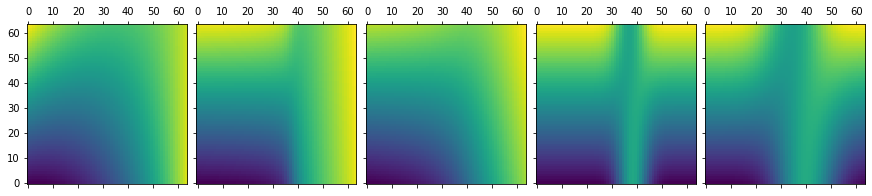

In [27]:
axs = (plt.figure(constrained_layout=True, figsize=(12, 12)).subplots(1, 5, sharex=True, sharey=True))
for k, e in enumerate([m_lComb, arcTan2, arcTan8, gauss4, gauss8]):
    axs[k].matshow(-np.transpose(e), origin='lower')
plt.show()

---

### Выбираем порог

In [28]:
def threshold(by, SLB):
    dt = np.array([[v, 0] for v in SLB[0]['bad'][by].to_list()] + [[v, 1] for v in SLB[3]['good'][by].to_list()])
    dt = dt[dt[:, 0].argsort()]
    tpr = np.cumsum(dt[:, 1])/np.sum(dt[:, 1])
    fpr = np.cumsum(1 - dt[:, 1])/(len(dt) - np.sum(dt[:, 1]))
    i = np.argmin([np.sqrt(x**2 + (1-y)**2) for x,y in np.transpose([tpr, fpr])])
    return dt[i][0]

In [29]:
threshold('matrix', SLB)

0.6262906682133951

---

In [30]:
from IPython.display import display, Javascript, HTML
import json 

display(Javascript("require.config({paths: {d3: 'https://d3js.org/d3.v5.min'}});"))
display(Javascript(filename="d3/hists.js"))
display(HTML(filename="d3/style.html"))

def hs(obj):
    v, x = np.histogram(obj, bins=200)
    return {'y': (v/v.sum()).tolist(), 'x': x.tolist()}

def hists(data):
    display(Javascript("""
        (function(e){ require(['hists'], function(fn) { fn(e.get(0), %s); }); })(element);
    """ % (json.dumps(data))))

def allHists(by, lim=None):
    P = {}
    for i in range(4):
        if lim == None:
            t = SLB[i]['bad'][by]
        else:
            t = SLB[i]['bad'].loc[(SLB[i]['bad'][by] < lim[1]) & (SLB[i]['bad'][by] > lim[0])][by]
        P[f"V{i} bad"] = hs(t)
    if lim == None:
        t = SLB[i]['good'][by]
    else:
        t = SLB[i]['good'].loc[(SLB[i]['good'][by] < lim[1]) & (SLB[i]['good'][by] > lim[0])][by]
    P[f"V{i} good"] = hs(t)
    hists(P)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [31]:
allHists('matrix')

<IPython.core.display.Javascript object>

In [32]:
allHists('lComb', (-10, 25))

<IPython.core.display.Javascript object>